In [1]:

import warnings

warnings.filterwarnings('ignore')



### Read COMPAS data


In [2]:

import pandas as pd

pd.set_option('display.max_columns', None)

df = pd.read_csv('compas-scores-two-years.csv', index_col='id')
df = df.reset_index(drop=True)


In [3]:

len(df)


7214

In [4]:

df.head()


,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [5]:

df['age_cat'].value_counts()


25 - 45            4109
Greater than 45    1576
Less than 25       1529
Name: age_cat, dtype: int64

In [6]:

#overwrite age cat

df['age_cat'] = pd.cut(df.age, bins = pd.IntervalIndex.from_tuples([(0, 30), (30, 45), (45, 60), (60, 120)], closed='left'))
df['age_cat']


0       [60, 120)
1        [30, 45)
2         [0, 30)
3         [0, 30)
4        [30, 45)
          ...    
7209      [0, 30)
7210      [0, 30)
7211     [45, 60)
7212     [30, 45)
7213      [0, 30)
Name: age_cat, Length: 7214, dtype: category
Categories (4, interval[int64]): [[0, 30) < [30, 45) < [45, 60) < [60, 120)]

In [7]:

df = df[['first', 'last', 'sex', 'age_cat', 'race', 'age']]


In [8]:

df.age.min()


18

In [9]:

df['race'].value_counts()


African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64


### Install the Bias Detector


In [11]:

%%capture

pip install --upgrade bias-detector


In [12]:

from bias_detector.BiasDetector import BiasDetector

bias_detector = BiasDetector(country='US')


In [13]:

age_cat_p_groups_correlations = dict()

for name, age_group in df.groupby('age_cat'):
    age_group = age_group.reset_index(drop=True)
    p_groups = bias_detector.get_p_groups(first_names=age_group['first'], last_names=age_group['last'])
    true_groups = pd.DataFrame(index=list(range(len(age_group))))
    true_groups['male'] = age_group['sex'] == 'Male'
    true_groups['female'] = age_group['sex'] == 'Female'
    true_groups['white'] = age_group['race'] == 'Caucasian'
    true_groups['black'] = age_group['race'] == 'African-American'
    true_groups['hispanic'] = age_group['race'] == 'Hispanic'
    true_groups = true_groups.fillna(0)
    true_groups = true_groups.astype(float)
    age_cat_p_groups_correlations[str(name)] = p_groups.corrwith(true_groups)


[0, 30)
[30, 45)
[45, 60)
[60, 120)


In [21]:

%%capture

!pip install --upgrade seaborn


In [22]:

import seaborn as sns

correlations = pd.DataFrame()

for group in ['male', 'female', 'white', 'black', 'hispanic']:
    for age_cat in df.age_cat:
        correlations.at[str(age_cat), group] = age_cat_p_groups_correlations[str(age_cat)][group]
    

In [23]:

correlations.sort_index(inplace=True, ascending=True)


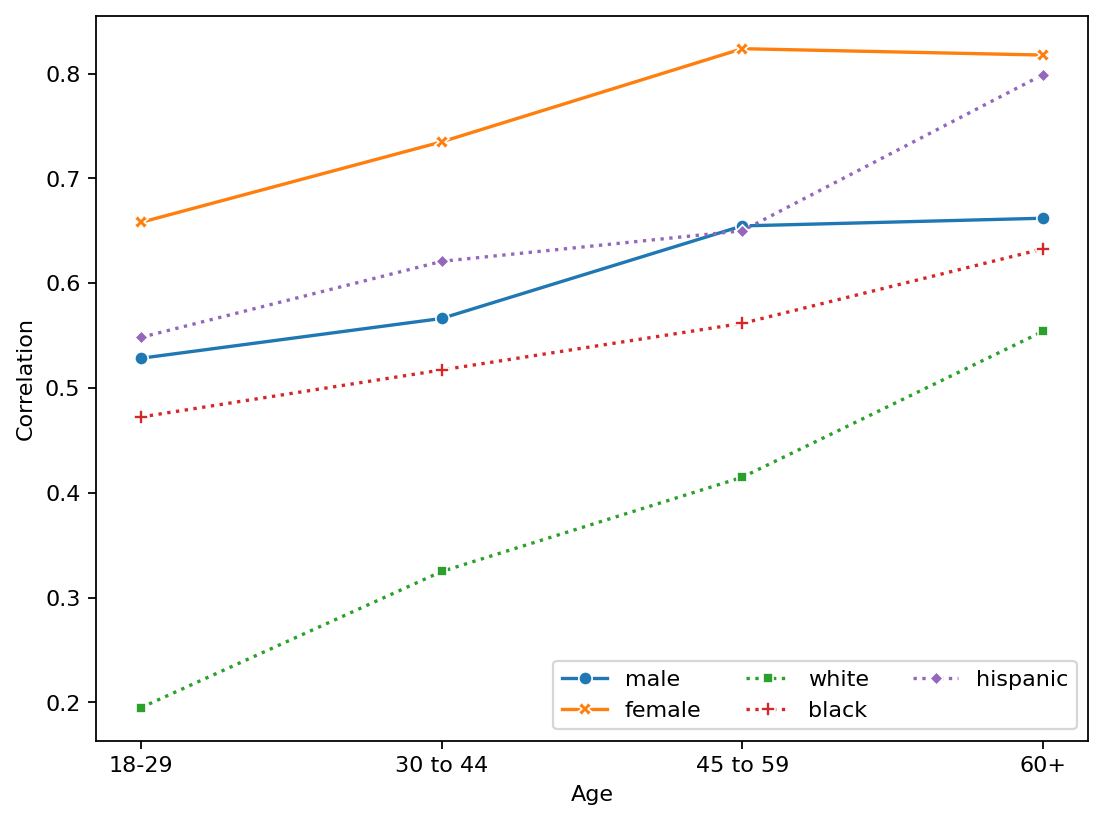

In [46]:

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np

figure(figsize=(8, 6), dpi=160)

ax = sns.lineplot(data=correlations[['male', 'female', 'white', 'black', 'hispanic']], markers=True)

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]


ax.set(xlabel='Age', ylabel='Correlation', xticklabels=['18-29', '30 to 44', '45 to 59', '60+'])

ax.lines[0].set_linestyle('-')
ax.lines[1].set_linestyle('-')

ax.lines[2].set_linestyle(':')
ax.lines[3].set_linestyle(':')
ax.lines[4].set_linestyle(':')


ax.legend((ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3], ax.lines[4]),("male","female","white","black","hispanic"),
           loc='lower right',fancybox=True,ncol=3)

plt.show()
